# Dataset Generation for Model Training

First, we add all the useful dependencies for image collection and processing.  
Be sure to be in the root directory of the project when executiong the following code cells.  
If any of the following imports fail, be sure to install the missing libraries through oyur package manager. I suggest _pip install <library\_name>_.  

In [1]:
import cv2
import time
import os
import uuid
from IPython.display import clear_output
import random
import shutil
import wget

We then define the path of the directory into which we will save and manipulate our dataset.  

In [2]:
imagePath = 'Tensorflow/Workspace/images/capturedimages'

Now we define the list of gesture classes _labels_, which will be used to generate data for the model to train onto.  
The _nImages_ variable specifies how many images of a single gesture shall be taken: the higher, the better variance you'll get in the final dataset. However, be warned that all the images for the dataset must be labeled manually, so choose wisely. We will exploit data augmentation to generate a bigger dataset with more variance, in order to improve the final model's generalization capabilities.  

In [6]:
labels = ['LeftL', 'LeftA', 'LeftO', 'LeftV', 'LeftOpenHand', 'RIndexUp', 'RIndexDown', 'RIndexLeft', 'RIndexRight', 'RIndexFront', 'RThumbBack', 'RClearC']
nImages = 25

We define some data aumentation functions to produce multiple output images from a single input.  
Since the gestures we want to recognize are hand-bound, since there are gestures exclusive to the right or left hand, we cannot perform horizontal mirroring. Vertical mirroring and rotations dont't make any sense in this case, since all the gestures are direction bound, so such transformations could make two different classes overlap with each other.  
The only useful data augmentation procedures we can exploit are thus vertical and horizontal shifts (or stretchs) and zoom transformations.  

In [7]:
def vertical_shift(input_img, ratio=0.2):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return input_img
    img = input_img.copy()
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = cv2.resize(img, (w, h), cv2.INTER_CUBIC)
    return img

def horizontal_shift(input_img, ratio=0.2):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return input_img
    img = input_img.copy()
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = cv2.resize(img, (w, h), cv2.INTER_CUBIC)
    return img

def zoom(input_img, value=0.85):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return input_img
    img = input_img.copy()
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = cv2.resize(img, (w, h), cv2.INTER_CUBIC)
    return img

The following code box will warn you about which gesture must be performed. The delay between each frame capture is of 2 seconds, but can be freely adjusted to whatever you need.  
Before the start of the capturing procedure for each class, the user is prompted to press Enter in an input box, to improve usability and provide mid-capture pause scenarios.  

In [8]:
frame_capture_delay = 2 #seconds
for label in labels:
    !mkdir {'Tensorflow\Workspace\images\capturedimages\\' + label}
    clear_output(wait=True)
    print('Collecting images for {}'.format(label))
    cap = cv2.VideoCapture(0)
    input()
    for imageNumber in range(nImages):
        time.sleep(frame_capture_delay)
        ret, frame = cap.read()
        tmpUUID = format(str(uuid.uuid1()))
        imageName = os.path.join(imagePath, label, label+'_'+f'{tmpUUID}.jpg')
        cv2.imwrite(imageName, frame)
        print('Collected')
        cv2.imshow('frame', frame)
        cv2.imwrite(os.path.join(imagePath, label, label+'_vshift_'+f'{tmpUUID}.jpg'),
                    vertical_shift(input_img=frame))
        cv2.imwrite(os.path.join(imagePath, label, label+'_hshift_'+f'{tmpUUID}.jpg'),
                    horizontal_shift(input_img=frame))
        cv2.imwrite(os.path.join(imagePath, label, label+'_zoom_'+f'{tmpUUID}.jpg'),
                    zoom(input_img=frame))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.destroyWindow('frame')
            break
    cap.release()
cv2.destroyWindow('frame')

Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected
Collected


At the end of the capture step, go into the _capturedimages_ directory.  
Check all the sub-directories generated output images, to ensure that all of them contain well structured data: if not, repeat the capture process by specifying only the number of images and classes you need to replace.  

The following cell will then move all the images from the class sub-directories to the _capturedimages_ directory.  
If you redefined the _labels_ list to capture some extra images, be sure to redefine the _labels_ list before executing the following cell, so that all files get correctly moved.

In [11]:
for label in labels:
    source_dir = imagePath + f"/{label}/"
    file_names = os.listdir(source_dir)
    for file_name in file_names:
        # Remove comment for verbose output
        #print(f"Moving {file_name} from {source_dir} to {imagePath}")
        shutil.move(os.path.join(source_dir, file_name), imagePath)
    os.rmdir(source_dir)

PermissionError: [WinError 32] Impossibile accedere al file. Il file è utilizzato da un altro processo: 'Tensorflow/Workspace/images/capturedimages/NOOP/'

# Dataset labeling  

All commands must be run from the root directory of the project, unless otherwise stated.  
As a first step, we will configure the environment variables for all the paths we are going to use.  

In [7]:
WORKSPACE_PATH = 'Tensorflow/Workspace'
SCRIPTS_PATH = 'Tensorflow/ConversionScript'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/trained-models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-model'
CONFIG_PATH = MODEL_PATH+'/custom_trained_model/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/custom_trained_model/'
CUSTOM_MODEL_NAME = 'custom_trained_model' 

The label map hereby generated contains all classes we want to train our model onto and assigns an integer id to each one.  
The map can be modified in order to account for number of different labels, just be sure that it features exactly the same classes previously defined in the _labels_ list.  
The code box down below will generate the _label_map.pbtxt_ file.  

In [ ]:
!mkdir "{ANNOTATION_PATH}"
label_map = []
id = 1
for label in labels:
    label_map.append({'name':f"{label}", 'id':f"{id}"})
    id = id + 1

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for entry in label_map:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(entry['name']))
        f.write('\tid:{}\n'.format(entry['id']))
        f.write('}\n')

## Clone submodules

If you cloned this repository without using the _-recursive_ flag, run the following codebox to get both the _labelImg_ and the _Tensorflow Model Zoo_ submodules.  

In [ ]:
!git submodule init
!git submodule update

## Label images with LabelImg

The follwing code cell moves the notebook's shell to the LabelImg directory and runs LabelImg.    

In the LabelImg instance that just opened, be sure to check in the upper left menu _View->Auto Save Mode_.  
Click onto _Open Dir_ on the left vertical menu bar and select the _collected images_ directory, then _Select directory_.  
Click onto _Change Save Dir_ on the left menu bar and select the _collected images_ directory, then _Select directory_.  

You should now see all the images you previously captured.  
Use _w_ to activate the draw bounding box utility and select the gesture in the image, confirming by clicking with the left mouse button. A small input window will open, asking you to assign a name to the object class for the bounding box you just drew: for consistency's sake, we used the same names as for the _labels_ list.  
Repeat the process until all the images have been labeled with exactly one label. It's possible to specify multiple bounding boxes for multiple elements in a single image, however this would make the dataset more complex to manage. Forthis reason, in this case, each dataset entry will contain one single gesture.  

In [8]:
%cd "labelImg"
!pyrcc5 -o libs/resources.py resources.qrc # Solves "No module named 'libs.resources'" bug, if present
!python labelImg.py
%cd ".."

e:\PoliTO\Machine Learning for Vision and Multimedia\labelImg


C:\Users\Marzio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\Scripts\pyrcc5: File does not exist '#'


Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\capturedimages\NOOP_0d44c910-63cf-11ec-9158-bcee7b8789e3.jpg -> Annotation:E:/PoliTO/Machine Learning for Vision and Multimedia/Tensorflow/Workspace/images/capturedimages\NOOP_0d44c910-63cf-11ec-9158-bcee7b8789e3.xml
Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\capturedimages\NOOP_0d44c910-63cf-11ec-9158-bcee7b8789e3.jpg -> Annotation:E:/PoliTO/Machine Learning for Vision and Multimedia/Tensorflow/Workspace/images/capturedimages\NOOP_0d44c910-63cf-11ec-9158-bcee7b8789e3.xml
Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\capturedimages\NOOP_1a6c42de-63cf-11ec-bc3f-bcee7b8789e3.jpg -> Annotation:E:/PoliTO/Machine Learning for Vision and Multimedia/Tensorflow/Workspace/images/capturedimages\NOOP_1a6c42de-63cf-11ec-bc3f-bcee7b8789e3.xml
Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\c

e:\PoliTO\Machine Learning for Vision and Multimedia\labelImg\labelImg.py:965: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  bar.setValue(bar.value() + bar.singleStep() * units)


Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\capturedimages\NOOP_497f6320-63cf-11ec-a13c-bcee7b8789e3.jpg -> Annotation:E:/PoliTO/Machine Learning for Vision and Multimedia/Tensorflow/Workspace/images/capturedimages\NOOP_497f6320-63cf-11ec-a13c-bcee7b8789e3.xml
Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\capturedimages\NOOP_497f6320-63cf-11ec-a13c-bcee7b8789e3.jpg -> Annotation:E:/PoliTO/Machine Learning for Vision and Multimedia/Tensorflow/Workspace/images/capturedimages\NOOP_497f6320-63cf-11ec-a13c-bcee7b8789e3.xml
Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\capturedimages\NOOP_956c48e5-63cf-11ec-816b-bcee7b8789e3.jpg -> Annotation:E:/PoliTO/Machine Learning for Vision and Multimedia/Tensorflow/Workspace/images/capturedimages\NOOP_956c48e5-63cf-11ec-816b-bcee7b8789e3.xml
Image:E:\PoliTO\Machine Learning for Vision and Multimedia\Tensorflow\Workspace\images\c

# Generate Tensorflow .record files  

First, we download the _generate\_tfrecord.py_ script from the Tensorflow Object Detection API page.  
The script will index the Train and Test partitions of the dataset, such that the training script can find the files.  

In [46]:
url = 'https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py'
wget.download(url, out=SCRIPTS_PATH, bar=wget.bar_thermometer)

[]

'Tensorflow/ConversionScript/generate_tfrecord.py'

We then must split our dataset into a training and a test partition. Be sure to evenly distribute samples for each class among the two sets, or else the training may yield underfitting or overfitting problems.  
We will use 25% of the dataset for the test partition and the remaining 75% for the testing partition. Since we have 100 samples for each class, it amounts to 25 test samples for each class.  
We won't use a validation partition, since the original model's structure from which we are performing transfer learning doesn't support it.   

In [9]:
number_test_samples = 25
!mkdir "{IMAGE_PATH + '/test'}"
!mkdir "{IMAGE_PATH + '/train'}"
for label in labels:
    file_names = [file for file in os.listdir(imagePath)
                  if file.endswith("jpg") if file.startswith(label + "_")]
    random.shuffle(file_names)
    index = 0
    for file_name in file_names:
        pre, ext = os.path.splitext(file_name)
        annotation_name = pre + ".xml"
        if(index < number_test_samples):
            # Remove comment for verbose output
            #print(f"Moving {file_name} and {annotation_name} from {imagePath} to {IMAGE_PATH + '/test'}")
            shutil.copy(src=imagePath + "/" + file_name, dst=IMAGE_PATH + '/test')
            shutil.copy(src=imagePath + "/" + annotation_name, dst=IMAGE_PATH + '/test')
            #shutil.move(os.path.join(source_dir, file_name), imagePath)
        else:
            # Remove comment for verbose output
            #print(f"Moving {file_name} and {annotation_name} from {imagePath} to {IMAGE_PATH + '/train'}")
            shutil.copy(src=imagePath + "/" + file_name, dst=IMAGE_PATH + '/train')
            shutil.copy(src=imagePath + "/" + annotation_name, dst=IMAGE_PATH + '/train')
        index = index + 1

Sottodirectory o file Tensorflow/Workspace/images/test gi� esistente.
Sottodirectory o file Tensorflow/Workspace/images/train gi� esistente.


In [10]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/Workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/Workspace/annotations/test.record


# Setup the transfer learning model  

Download, if not present, the _ssd\_mobilenet\_v2\_fpnlite\_320x320\_coco17\_tpu-8_ we'll later use for transfer learning.  
This can be done with the following code cell.  

In [48]:
url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
wget.download(url, out=PRETRAINED_MODEL_PATH, bar=wget.bar_thermometer)
!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

[]

x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/checkpoint
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0.index
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.data-00000-of-00001
x ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/variables/variables.index


We will now copy the _pipeline.config_ file into the path to which our trained model will be saved to.  

In [53]:
source = PRETRAINED_MODEL_PATH + '/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'
destination = MODEL_PATH + '/' + CUSTOM_MODEL_NAME
!mkdir "{MODEL_PATH + '/' + CUSTOM_MODEL_NAME}"
shutil.copy(src=source, dst=destination)

'Tensorflow/Workspace/trained-models/custom_trained_model\\pipeline.config'

The _pipeline.config_ file must now be updated with the local paths, number of classes and other characteristics of our new model.  

In [55]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [69]:
CONFIG_PATH = MODEL_PATH + '/' + CUSTOM_MODEL_NAME + '/pipeline.config'
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [70]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

At this point, be sure that the _pipeline_config.model.ssd.num_classes_ variable in the code box down here equals exactly the number of labels you previously specified. In our case it will be 12.

In [72]:
pipeline_config.model.ssd.num_classes = 12
pipeline_config.train_config.batch_size = 8
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

The modified entries of the _pipeline.config_ file are then written onto the file.

In [73]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)  

# Model Training  

The following code box will print out a command.  
It must be copied and run in a shell located at the root directory of the project.  

It is highly suggested to configure a GPU for training, as doing so will speed up by a significant margin the computation time, although this is not strictly necessary. Detailed instructions for installing the Tensorflow Object Detection API can be found on the [TF Object Detection API Installation Tutorial page](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html).  

The number of training steps can be configured by changing the _--num\_train\_steps_ value.  
In our case, the model has been trained onto a machine equipped with an _Intel i5-11600K_ CPU and accelerated through an _NVidia RTX 2060 6GB_ GPU. The process required <time_required> hours to complete the training.

The _training.log_ file is removed before the start of a new training to not mix the statistics.  

In [83]:
num_train_steps = 40000
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps={}""".format(APIMODEL_PATH, MODEL_PATH, CUSTOM_MODEL_NAME, MODEL_PATH, CUSTOM_MODEL_NAME, num_train_steps))
os.remove("training.log")

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/Workspace/trained-models/custom_trained_model --pipeline_config_path=Tensorflow/Workspace/trained-models/custom_trained_model/pipeline.config --num_train_steps=40000


The _model_lib_v2.py_ script has been modified in order to redirect the training history printed on stdout also onto a file.    
We will now process this _training.log_ file, found in the root directory, in order to extract statistics from the training.  

In [2]:
import re

statistics = ['classification_loss', 'localization_loss', 'regularization_loss', 'total_loss', 'learning_rate']
history_dict = {k: [] for k in statistics}

fp = open('training.log', 'r')
line = fp.readline()
while line:
    for statistic in statistics:
        value = re.findall(r"[-+]?\d*\.\d+|\d+", line)
        history_dict[statistic].append(value[0])
        line = fp.readline()
fp.close()
num_entries = len(history_dict['classification_loss'])

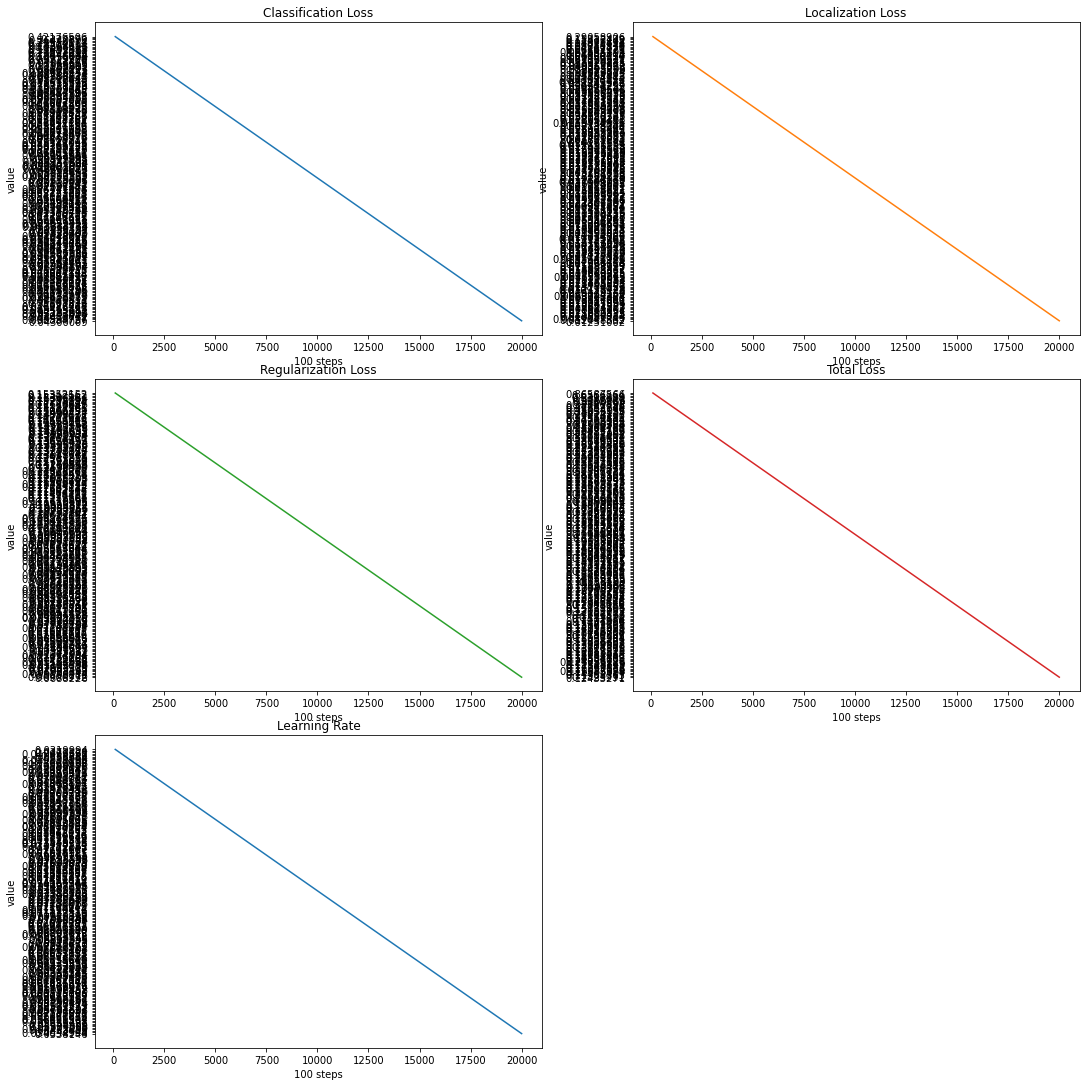

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(15, 15)
axs[0, 0].plot(np.linspace(100, 100 * num_entries, num_entries), history_dict['classification_loss'])
axs[0, 0].invert_yaxis()
axs[0, 0].set_title('Classification Loss')
axs[0, 1].plot(np.linspace(100, 100 * num_entries, num_entries), history_dict['localization_loss'], 'tab:orange')
axs[0, 1].invert_yaxis()
axs[0, 1].set_title('Localization Loss')
axs[1, 0].plot(np.linspace(100, 100 * num_entries, num_entries), history_dict['regularization_loss'], 'tab:green')
axs[1, 0].invert_yaxis()
axs[1, 0].set_title('Regularization Loss')
axs[1, 1].plot(np.linspace(100, 100 * num_entries, num_entries), history_dict['total_loss'], 'tab:red')
axs[1, 1].invert_yaxis()
axs[1, 1].set_title('Total Loss')
axs[2, 0].plot(np.linspace(100, 100 * num_entries, num_entries), history_dict['learning_rate'], 'tab:blue')
axs[2, 0].invert_yaxis()
axs[2, 0].set_title('Learning Rate')
axs[2, 1].set_visible(False)
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='100 steps', ylabel='value')